In [1]:
import ROOT

import os


from my_utils import *
from matplotlib import pyplot as plt
import numpy as np

data_dir = make_data_dir()

c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,400)

from ROOT import gInterpreter, gSystem
gInterpreter.ProcessLine('#include "/workdir/skew_norm.C"')

Welcome to JupyROOT 6.14/04


0

In [2]:
clear_data_dir()

In [3]:

# prefer fully unpacked over previews

possible_file_names = [
 "joint_tree.root",
 "joint_tree_prev5000.root",
 "joint_tree_prev1000.root"
]

id="id021"

# x scan trafo board
#id="id051b15"
#id="id051b30"

#nice example for x scan, pAC, 1750V
#id="id062"

## auto detect scan type ##

root_file_name = ""

for i in range(0,len(possible_file_names)):
  root_file_name = possible_file_names[i]
  file_list = os.popen('  find /workdir/data -iname "*{:s}" | grep {:s} | sort '.format(
    root_file_name,id)).read().split("\n")
  if (len(file_list) > 1):
    break

#print("len: {:d}".format(len(file_list)))
#file_list = file_list[0:60]
del file_list[-1]
file_list

[]

In [4]:
# run the correlation macro again, in case something was updated

for file in file_list:
  dirname = os.path.dirname(file)
  os.system("cd /workdir/; ./recorrelate.sh {:s}".format(dirname))

In [5]:
import re

X =  []
PHI =  []
THR = []
MICRO = []

print ("X")

pattern =  re.compile(".*_x([0-9E+\-.]+).*/{:s}".format(root_file_name))
for file in file_list:
  #print(file , end="   x: ")
  match = re.search(pattern, file)
  if match:
    x = match.groups()[0]
    X += [float(x)]

print (X)

X
[]


In [6]:
print ("PHI")

pattern =  re.compile(".*_phi([0-9E+\-.]+).*/{:s}".format(root_file_name))
for file in file_list:
  #print(file , end="   x: ")
  match = re.search(pattern, file)
  if match:
    phi = match.groups()[0]
    PHI += [float(phi)]

print (PHI)

PHI
[]


In [7]:
print ("THR")

pattern =  re.compile(".*_thr([0-9E+\-.]+).*/{:s}".format(root_file_name))
for file in file_list:
  #print(file , end="   x: ")
  match = re.search(pattern, file)
  if match:
    thr = match.groups()[0]
    THR += [float(thr)]

print (THR)

THR
[]


In [8]:
print ("MICRO")

pattern =  re.compile(".*_micro([0-9E+\-.]+).*/{:s}".format(root_file_name))
for file in file_list:
  #print(file , end="   x: ")
  match = re.search(pattern, file)
  if match:
    micro = match.groups()[0]
    MICRO += [float(micro)]

print (MICRO)

MICRO
[]


In [9]:
# default variable
varname = "X"
#varname  = "THR"
#varname = "PHI"
#varname = "MICRO"

varname_list = ["X","THR","PHI","MICRO"]
len_list     = np.array([len(set(X)),len(set(THR)),len(set(PHI)),len(set(MICRO))])

varname = varname_list[ np.argmax(len_list) ]


In [10]:
#def extract_info(file):

c = ROOT.TCanvas("myCanvasName","The Canvas Title",640,480)

const_list = []
mean_list = []
sigma_list = []
entries_list = []

fish_const_list = []
fish_mean_list = []
fish_sigma_list = []
fish_entries_list = []

const_list_scut = []
mean_list_scut = []
sigma_list_scut = []
entries_list_scut = []

const_list_scut_b = []
mean_list_scut_b = []
sigma_list_scut_b = []
entries_list_scut_b = []

fish_const_list_scut = []
fish_mean_list_scut = []
fish_sigma_list_scut = []
fish_entries_list_scut = []

gif_out_list = []

VAR = X

if varname == "X":
  VAR = X
if varname == "THR":
  VAR = THR
if varname == "PHI":
  VAR = PHI
if varname == "MICRO":
  VAR = MICRO

for i in range(0,len(VAR)):
    
  file=file_list[i]
  var = VAR[i]

##################################################
##                    vw ana                    ##
##################################################


  f = ROOT.TFile(file)
  tree = f.Get("joint_tree")
  #tree.Draw("tot:t1 >> potato(500,0,500e-9,500,0,500e-9)",
  #          "wire == 10 && layer == 1 && chamber == 2",
  #          "colz")

  ### triggers for normalization
  tree.Draw("t1 >> t1(200,-200,800)",
            "chan == 35103",
            "colz")
  t1 = f.Get("t1")
  no_triggers = t1.GetEntries()

  print ("var: {:3.3f} {:s}, no_triggers: {:d}".format(var,varname,int(no_triggers)))
  

  ### t1 of desired wire, wide
  tree.Draw("t1 >> t1(1000,-200,800)",
            "chamber == 2 && layer == 1 && wire == 10",
            "colz")
  try:
    os.mkdir("{:s}/t1_raw_wide".format(data_dir))  
  except:
    pass
  gif_out_list += ["t1_raw_wide"]
  c.SaveAs("{:s}/t1_raw_wide/{:3.3f}_t1_wide.png".format(data_dir,var))

  ### t1 of desired wire
  tree.Draw("t1 >> t1(200,-50,100)",
            "chamber == 2 && layer == 1 && wire == 10",
            "colz")
  t1 = f.Get("t1")
  #t1.SetTitle("t1 wire 10, layer 1")
  t1.GetXaxis().SetTitle("t1 (ns)")
  t1.GetYaxis().SetTitle("tot (s)")
  #t1.GetXaxis().SetRangeUser()
  t1.Draw()
  ROOT.gStyle.SetOptFit(1)
  params = ROOT.fit_alt_skewed(t1)

  try:
    const_list   += [params.GetAt(0)/no_triggers]
    mean_list    += [params.GetAt(4)]
    sigma_list   += [params.GetAt(5)]
    entries_list += [(t1.Integral(t1.FindBin(0),t1.FindBin(80)))/no_triggers]   
  except:
    const_list   += [0]
    mean_list    += [0]
    sigma_list   += [0]
    entries_list += [0]
  try:
   os.mkdir("{:s}/t1_raw".format(data_dir))  
  except:
    pass
  gif_out_list += ["t1_raw"]
  c.SaveAs("{:s}/t1_raw/{:3.3f}_t1.png".format(data_dir,var))
  f.Close()
    
    
    
##################################################
##                   fish ana                   ##
##################################################
    
    
    
  f = ROOT.TFile(file.replace("joint_tree","correlation"))

  fish = f.Get("meta_fish_cut")
  fish.Draw("colz")
  try:
    os.mkdir("{:s}/fish_raw/".format(data_dir))  
  except:
    pass
  gif_out_list += ["fish_raw"]
  c.SaveAs("{:s}/fish_raw/{:3.3f}_fish.png".format(data_dir,var))
  fish_proj_full= fish.ProjectionX("fish_proj_full", 1, 120) # 

  fish_proj= fish.ProjectionX("fish_proj", 61, 65) # -10/+10
  fish_proj.Draw()


  t1 = fish_proj
  #t1.SetTitle("t1 wire 10, layer 1")
  t1.GetXaxis().SetTitle("t1 (ns)")
  t1.GetYaxis().SetTitle("tot (s)")
  #t1.GetXaxis().SetRangeUser()
  t1.Draw()
  ROOT.gStyle.SetOptFit(1)
  params = ROOT.fit_alt_skewed(t1)
  
  try:
    os.mkdir("{:s}/fish_raw_proj/".format(data_dir))  
  except:
    pass
  gif_out_list += ["fish_raw_proj"]
  c.SaveAs("{:s}/fish_raw_proj/{:3.3f}_fish_proj.png".format(data_dir,var))


  try:
    fish_const_list   += [params.GetAt(0)/no_triggers]
    fish_mean_list    += [params.GetAt(4)]
    fish_sigma_list   += [params.GetAt(5)]
    fish_entries_list += [(t1.Integral(t1.FindBin(0),t1.FindBin(80)))/no_triggers]   
  except:
    fish_const_list   += [0]
    fish_mean_list    += [0]
    fish_sigma_list   += [0]
    fish_entries_list += [0]

##################################################
##                scinti_cut ana                ##
##################################################
  no_triggers = 1
  try:
    # number of triggers for normalization
    no_triggers = 1
    t1 = f.Get("scinti_t1_scinti_cut")
    no_triggers = t1.GetEntries()
    print ("var: {:3.3f} {:s}, scinti_cut no_triggers: {:d}".format(var,varname,int(no_triggers)))

    ### t1 of desired wire
    t1 = f.Get("wire_a_t1_scinti_cut")
    #t1.SetTitle("t1 wire 10, layer 1")
    t1.SetTitle("wire_a_t1_scinti_cut {:3.3f} {:s}".format(var,varname))
    t1.GetXaxis().SetTitle("t1 (ns)")
    #t1.GetYaxis().SetTitle("tot (s)")
    t1.GetXaxis().SetRangeUser(-20,100)
    t1.Draw()
    
    params = ROOT.fit_alt_skewed(t1)
    
    const_list_scut   += [params.GetAt(0)/no_triggers]
    mean_list_scut    += [params.GetAt(4)]
    sigma_list_scut   += [params.GetAt(5)]
    entries_list_scut += [(t1.Integral(t1.FindBin(0),t1.FindBin(80)))/no_triggers]   
    try:
      os.mkdir("{:s}/t1_scut_wire_a/".format(data_dir))  
    except:
      pass
    gif_out_list += ["t1_scut_wire_a"]
    c.SaveAs("{:s}/t1_scut_wire_a/{:3.3f}_t1_scut.png".format(data_dir,var))
    
    ### t1 of desired wire
    t1 = f.Get("wire_b_t1_scinti_cut")
    #t1.SetTitle("t1 wire 10, layer 1")
    t1.SetTitle("wire_b_t1_scinti_cut {:3.3f} {:s}".format(var,varname))
    t1.GetXaxis().SetTitle("t1 (ns)")
    #t1.GetYaxis().SetTitle("tot (s)")
    t1.GetXaxis().SetRangeUser(-20,100)
    t1.Draw()
    
    params = ROOT.fit_alt_skewed(t1)
    
    const_list_scut_b   += [params.GetAt(0)/no_triggers]
    mean_list_scut_b    += [params.GetAt(4)]
    sigma_list_scut_b   += [params.GetAt(5)]
    entries_list_scut_b += [(t1.Integral(t1.FindBin(0),t1.FindBin(80)))/no_triggers]   

    try:
      os.mkdir("{:s}/t1_scut_wire_b/".format(data_dir))  
    except:
      pass
    gif_out_list += ["t1_scut_wire_b"]
    c.SaveAs("{:s}/t1_scut_wire_b/{:3.3f}_t1_scut_b.png".format(data_dir,var))
    
    ##################################################
    ##                potato wire a                 ##
    ##################################################
    
    potato = f.Get("wire_a_potato_scinti_cut")
    #potato.SetTitle("potato wire 10, layer 1")
    potato.GetXaxis().SetTitle("potato (ns)")
    potato.SetTitle("wire_a_potato_scinti_cut {:3.3f} {:s}".format(var,varname))
    #potato.GetYaxis().SetTitle("tot (s)")
    potato.GetXaxis().SetRangeUser(-20,100)
    potato.Draw("colz")

    try:
      os.mkdir("{:s}/potato_scut_wire_a/".format(data_dir))  
    except:
      pass
    gif_out_list += ["potato_scut_wire_a"]
    c.SaveAs("{:s}/potato_scut_wire_a/{:3.3f}_potato_scut_a.png".format(data_dir,var))
    
    
    ##################################################
    ##                potato wire b                 ##
    ##################################################
    
    potato = f.Get("wire_b_potato_scinti_cut")
    #potato.SetTitle("potato wire 10, layer 1")
    potato.GetXaxis().SetTitle("potato (ns)")
    potato.SetTitle("wire_b_potato_scinti_cut {:3.3f} {:s}".format(var,varname))
    #potato.GetYaxis().SetTitle("tot (s)")
    potato.GetXaxis().SetRangeUser(-20,100)
    potato.Draw("colz")

    try:
      os.mkdir("{:s}/potato_scut_wire_b/".format(data_dir))  
    except:
      pass
    gif_out_list += ["potato_scut_wire_b"]
    c.SaveAs("{:s}/potato_scut_wire_b/{:3.3f}_potato_scut_b.png".format(data_dir,var))
    
    
    
  except:
    const_list_scut   += [0]
    mean_list_scut    += [0]
    sigma_list_scut   += [0]
    entries_list_scut += [0]
    const_list_scut_b   += [0]
    mean_list_scut_b    += [0]
    sigma_list_scut_b   += [0]
    entries_list_scut_b += [0]
    

##################################################
##                scinti_cut fish ana                ##
##################################################


  try:
    fish = f.Get("meta_fish_scinti_cut")
    fish.Draw("colz")
    try:
      os.mkdir("{:s}/fish_scut/".format(data_dir))  
    except:
      pass
    gif_out_list += ["fish_scut"]
    c.SaveAs("{:s}/fish_scut/{:3.3f}_fish_scinti_cut.png".format(data_dir,var))
  
    fish_proj_full= fish.ProjectionX("fish_proj_full", 1, 120) # 
    fish_proj= fish.ProjectionX("fish_proj", 61, 65) # -10/+10
    fish_proj.Draw()
  
  
    t1 = fish_proj
    #t1.SetTitle("t1 wire 10, layer 1")
    t1.GetXaxis().SetTitle("t1 (ns)")
    t1.GetYaxis().SetTitle("tot (s)")
    #t1.GetXaxis().SetRangeUser()
    t1.Draw()
    ROOT.gStyle.SetOptFit(1)
  
    params = ROOT.fit_alt_skewed(t1)
    
    fish_const_list_scut   += [params.GetAt(0)/no_triggers]
    fish_mean_list_scut    += [params.GetAt(4)]
    fish_sigma_list_scut   += [params.GetAt(5)]
    fish_entries_list_scut += [(t1.Integral(t1.FindBin(0),t1.FindBin(80)))/no_triggers]   
    try:
      os.mkdir("{:s}/fish_proj_scut/".format(data_dir))  
    except:
      pass
    gif_out_list += ["fish_proj_scut"]
    c.SaveAs("{:s}/fish_proj_scut/{:3.3f}_fish_proj_scinti_cut.png".format(data_dir,var))
  except:
    fish_const_list_scut   += [0]
    fish_mean_list_scut    += [0]
    fish_sigma_list_scut   += [0]
    fish_entries_list_scut += [0]

  f.Close()




Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvasName


In [11]:
len(entries_list_scut)

0

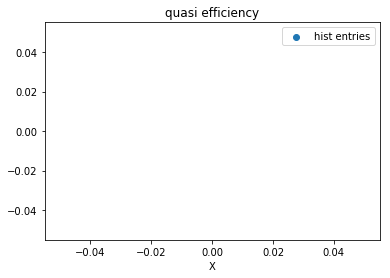

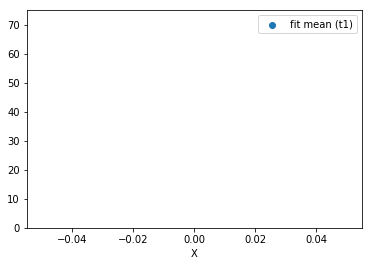

ValueError: zero-size array to reduction operation maximum which has no identity

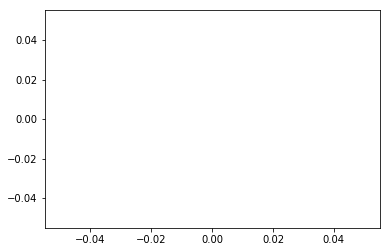

In [12]:
VAR = VAR[0:len(entries_list)]

##################################################
##                    vw ana                    ##
##################################################


plt.scatter(VAR,entries_list,label="hist entries")
#plt.plot(VAR,entries_list,label="hist entries")
#plt.ylim(0,np.max(entries_list)*1.2)
plt.legend()
plt.xlabel(varname)
plt.title("quasi efficiency")
plt.show()

plt.scatter(VAR,mean_list,label="fit mean (t1)")
#plt.plot(VAR,mean_list,label="fit mean (t1)")
#plt.ylim(0,np.max(mean_list)*1.2)
plt.legend()
plt.xlabel(varname)
plt.ylim(0,75)
plt.show()

plt.scatter(VAR,const_list,label="fit const (t1)")
#plt.plot(VAR,const_list,label="fit const (t1)")
plt.ylim(0,np.max(const_list)*1.2)
plt.legend()
plt.xlabel(varname)
#plt.ylim(0,0.3)
plt.show()

plt.scatter(VAR,sigma_list,label="fit sigma (t1)")

#plt.plot(VAR,sigma_list,label="fit sigma (t1)")
#plt.ylim(0,np.max(sigma_list)*1.2)
plt.ylim(0,20)
plt.legend()
plt.xlabel(varname)
plt.show()

#area_list = np.array(const_list) * np.array(sigma_list)

#plt.scatter(VAR,area_list,label="gaus area")
#plt.ylim(0,np.max(area_list))
#plt.legend()
#plt.ylim(0,5)
#plt.show()

In [ ]:
##################################################
##                   fish ana                   ##
##################################################


plt.scatter(VAR,fish_entries_list,label="hist entries")
#plt.plot(VAR,fish_entries_list,label="hist entries")
plt.ylim(0,np.max(fish_entries_list)*1.2)
plt.legend()
plt.title("quasi efficiency")
plt.xlabel(varname)
show(plt)

plt.scatter(VAR,fish_mean_list,label="fit mean (t1)")
#plt.plot(VAR,fish_mean_list,label="fit mean (t1)")
plt.ylim(0,np.max(fish_mean_list)*1.2)
plt.legend()
#plt.ylim(0,75)
plt.xlabel(varname)
show(plt)

plt.scatter(VAR,fish_const_list,label="fit const (t1)")
#plt.plot(VAR,fish_const_list,label="fit const (t1)")
plt.ylim(0,np.max(fish_const_list)*1.2)
plt.legend()
#plt.ylim(0,0.3)
plt.xlabel(varname)
show(plt)

plt.scatter(VAR,fish_sigma_list,label="fit sigma fish (t1)")
plt.scatter(VAR,np.array(fish_sigma_list)/np.sqrt(2),label="fit sigma fish /sqrt2 (t1)")
plt.scatter(VAR,sigma_list,label="fit sigma direct")
#plt.plot(VAR,fish_sigma_list,label="fit sigma (t1)")
plt.ylim(0,np.max(fish_sigma_list)*1.2)
plt.ylim(0,20)
plt.legend()
plt.xlabel(varname)
show(plt)



In [ ]:


##################################################
##                scinti_cut ana                ##
##################################################



plt.scatter(VAR,entries_list,label="wire a no cut",alpha=0.2)
plt.scatter(VAR,entries_list_scut,label="wire a")
plt.scatter(VAR,entries_list_scut_b,label="wire b (pAC)")
#plt.plot(VAR,entries_list_scut,label="hist entries")
#plt.ylim(0,np.max(entries_list_scut)*1.2)
plt.legend()
plt.xlabel(varname)
plt.title("quasi efficiency from hist entries")
plt.show()

plt.scatter(VAR,mean_list,label="wire a no cut",alpha=0.2)
plt.scatter(VAR,mean_list_scut,label="wire a")
plt.scatter(VAR,mean_list_scut_b,label="wire b (pAC)")
#plt.plot(VAR,mean_list_scut,label="fit mean (t1)")
#plt.ylim(0,np.max(mean_list_scut)*1.2)
plt.legend()
plt.xlabel(varname)
plt.ylim(0,75)
plt.title("t1 (gaus mean)")
plt.show()

plt.scatter(VAR,const_list,label="wire a no cut",alpha=0.2)
plt.scatter(VAR,const_list_scut,label="wire a")
plt.scatter(VAR,const_list_scut_b,label="wire b (pAC)")
#plt.plot(VAR,const_list_scut,label="fit const (t1)")
plt.ylim(0,np.max(const_list_scut)*1.2)
plt.legend()
plt.xlabel(varname)
plt.title("fit const t1")
#plt.ylim(0,0.3)
plt.show()

plt.scatter(VAR,sigma_list,label="wire a no cut",alpha=0.2)
plt.scatter(VAR,sigma_list_scut,label="wire a")
plt.scatter(VAR,sigma_list_scut_b,label="wire b (pAC) ")

#plt.plot(VAR,sigma_list_scut,label="fit sigma (t1)")
plt.ylim(0,np.max(sigma_list_scut)*1.2)
plt.ylim(0,20)
plt.legend()
plt.xlabel(varname)
plt.title("fit sigma / t1 sttdev")
plt.show()

#area_list_scut = np.array(const_list_scut) * np.array(sigma_list_scut)

#plt.scatter(VAR,area_list_scut,label="gaus area")
#plt.ylim(0,np.max(area_list_scut))
#plt.legend()
#plt.ylim(0,5)
#plt.show()

In [ ]:
##################################################
##               scut fish ana                  ##
##################################################


plt.scatter(VAR,fish_entries_list,label="hist entries",alpha=0.2)
plt.scatter(VAR,fish_entries_list_scut,label="hist entries scut")
#plt.plot(VAR,fish_entries_list_scut,label="hist entries")
plt.ylim(0,np.max(fish_entries_list_scut)*1.2)
plt.legend()
plt.title("quasi efficiency")
plt.xlabel(varname)
show(plt)

plt.scatter(VAR,fish_mean_list,label="fit mean (t1)",alpha=0.2)
plt.scatter(VAR,fish_mean_list_scut,label="fit mean (t1) scut")
#plt.plot(VAR,fish_mean_list_scut,label="fit mean (t1)")
plt.ylim(0,np.max(fish_mean_list_scut)*1.2)
plt.legend()
#plt.ylim(0,75)
plt.xlabel(varname)
show(plt)

plt.scatter(VAR,fish_const_list,label="fit const (t1)",alpha=0.2)
plt.scatter(VAR,fish_const_list_scut,label="fit const (t1) scut")
#plt.plot(VAR,fish_const_list_scut,label="fit const (t1)")
plt.ylim(0,np.max(fish_const_list_scut)*1.2)
plt.legend()
#plt.ylim(0,0.3)
plt.xlabel(varname)
show(plt)

plt.scatter(VAR,fish_sigma_list,label="fit sigma fish (t1)",alpha=0.2)
plt.scatter(VAR,fish_sigma_list_scut,label="fit sigma fish (t1) scut")
plt.scatter(VAR,np.array(fish_sigma_list_scut)/np.sqrt(2),label="fit sigma fish /sqrt2 (t1) scut")
plt.scatter(VAR,sigma_list_scut,label="fit sigma direct scut")
#plt.plot(VAR,fish_sigma_list_scut,label="fit sigma (t1)")
plt.ylim(0,np.max(fish_sigma_list_scut)*1.2)
plt.ylim(0,20)
plt.legend()
plt.xlabel(varname)
show(plt)


In [1]:
from IPython.display import Image

for subfolder in sorted(list(set(gif_out_list))):
  print("animating graphics in {:s}".format(subfolder))
  os.system("cd {:s}/{:s}; convert -alpha off -delay 200 -loop 0 *png output.gif ".format(data_dir,subfolder))
  with open('{:s}/{:s}/output.gif'.format(data_dir,subfolder),'rb') as f:
    display(Image(data=f.read(), format='png'))
    

NameError: name 'gif_out_list' is not defined

In [ ]:
#archive(label="{:s}_{:s}_{:s}".format(id,root_file_name,varname))